### The Dataset is stored in the ```dataset``` folder 
downloaded from ```http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip```
### The GloVe vector embeddings are in the ```glove``` folder 
downloaded from ```https://github.com/stanfordnlp/GloVe```
### The Counter-Fitted vectors are in the ```counter-fitted``` folder
download from ```https://github.com/nmrksic/counter-fitting/blob/master/word_vectors/counter-fitted-vectors.txt.zip```
(see referenced paper [20])


# Import dependecies 
Start by importing all the required libraries

In [1]:
"""
Python 3.8.5
Tensorflow 2.2.0
Keras 2.4.3

wordcloud 1.8.0
"""
import datetime
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer


import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import string # use this to remove punctuation from tweets e.g. string.punctuation
import random as rnd
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import pickle
import os
import re


############ CONSTANTS ##################################

# DATA FILE LOCATIONS
DATA_SET_TWITTER = "dataset/train.csv"
DATA_SET_IMDB = "dataset/imdb/"
COUNTER_FITTED_VECTORS = "counter-fitted/counter-fitted-vectors.txt" 
GLOVE_EMBEDDINGS = "glove/glove.840B.300d.txt"

# DATA SPLIT & VOCABULARY SIZE
TRAINING_SPLIT = 0.8

In [2]:
# words to exclude from the wordcloud
print(type(STOPWORDS),"\n")
print(STOPWORDS)

<class 'set'> 

{'and', "she'll", "it's", 'how', "you'll", "shouldn't", "they'd", 'shall', "let's", 'any', 'about', 'are', 'down', 'of', 'but', 'our', 'com', 'you', "i'll", 'when', 'over', 'her', "couldn't", 'also', 'other', 'an', 'here', 'my', "he'd", "we'd", 'them', 'yourself', 'like', 'been', 'his', 'once', "she's", 'who', 'on', 'for', 'from', "there's", "he's", 'its', "why's", 'some', "how's", 'she', 'hence', 'your', 'this', "hasn't", 'himself', "doesn't", 'these', 'no', "shan't", "that's", 'however', 'through', "we've", 'themselves', 'had', "don't", "we'll", "aren't", 'being', 'nor', 'same', 'as', 'yourselves', 'or', 'would', "what's", 'at', 'under', 'before', 'up', "wouldn't", "you'd", 'i', 'get', 'with', 'again', "haven't", 'can', 'each', "mustn't", "where's", 'if', 'have', "didn't", 'yours', 'a', "isn't", "hadn't", 'all', 'they', 'such', 'has', 'itself', 'by', "won't", 'because', 'otherwise', 'having', "they're", 'between', "they've", 'the', 'too', 'else', "who's", 'until', 'it

# Process dataset
### Read the dataset file and return a data frame


In [3]:
def process_dataset_Sentiment140(file_path: str ):
    # load the data file into a data frame
    df = pd.read_csv(file_path, encoding='latin-1', header=None) # changed encoding to 'latin-1'
    
    # Rename the columns so we can reference them later
    df.columns = ['sentiment', 'id', 'date', 'query', 'user_id', 'text']
    
    # drop all the columns we don't need
    df = df.drop(['id', 'date', 'query', 'user_id'], axis=1) 
    
    # change all 4's to 1's (just for neatness)
    df.loc[df['sentiment'] == 4, 'sentiment'] = 1
    
    # sort all the rows by the sentiment columns
    df.sort_values(by=['sentiment'])
    
    return df

def process_dataset_IMDB(file_path: str):
    """
    Need to redo this to deal with the IMDB dataset - rename columns to match the sentiments140 dataset so we can 
    re-use all th e below methods without changing anything
    """

    
    pos_train = file_path + "train/pos"
    pos_train_files = [pos_train + '/' + x for x in os.listdir(pos_train) if x.endswith('.txt')]
   
    pos_test = file_path + "test/pos"
    pos_test_files = [pos_test + '/' + x for x in os.listdir(pos_test) if x.endswith('.txt')]
    
    # list containing the file path to all positive sentiment text
    all_pos = pos_train_files + pos_test_files
    
    
    neg_train = file_path + "train/neg"
    neg_train_files = [neg_train + '/' + x for x in os.listdir(neg_train) if x.endswith('.txt')]
    
    neg_test = file_path + "test/neg"
    neg_test_files = [neg_test + '/' + x for x in os.listdir(neg_test) if x.endswith('.txt')]
    
    # list containing the file path to all negative sentiment text
    all_neg = neg_train_files + neg_test_files
    
    df_pos = pd.DataFrame(columns = ['sentiment', 'text'])
    for i, l in enumerate(all_pos):
            f = open(all_pos[i])
            line = f.readline()
            df_pos = df_pos.append({'sentiment': 1, 'text': line}, ignore_index=True)
            f.close()
    
    df_neg = pd.DataFrame(columns = ['sentiment', 'text'])
    for i, l in enumerate(all_neg):
            f = open(all_neg[i])
            line = f.readline()
            df_neg = df_neg.append({'sentiment': 0, 'text': line}, ignore_index=True)
            f.close()
    
    print("neg shape: ", df_neg.shape)
    print("pos shape: ", df_pos.shape)
    frames = [df_neg, df_pos]
    data_file = pd.concat(frames, axis=0)
    
    return data_file 
    
    

In [4]:

# data_set.shape
# data_set.head(100)
# for index, row in data_set.iterrows():
#     if row['sentiment'] == 0:
#         print(index)
#         break


### Read in the dataset file and show the first 5 rows of the data frame


In [5]:
data_frame  = process_dataset_IMDB(DATA_SET_IMDB)

#data_frame = process_dataset_Sentiment140(DATA_SET_TWITTER)
data_frame.head()

neg shape:  (25000, 2)
pos shape:  (25000, 2)


,sentiment,text
0,0,"I found the documentary entitled Fast, Cheap, ..."
1,0,This is an embarrassment to everyone and every...
2,0,"The cast although nothing special, all do an O..."
3,0,Investigative reporter Darren McGavin (as Carl...
4,0,This movie is horrible. Everything in it has b...


### Plot the data
#### We see that we have 2 types of sentiments, ```0 = negative``` and ```1 = positive```. We have 25,000 data points for each type of sentiment

Text(0.5, 1.0, 'Sentiment Distribution')

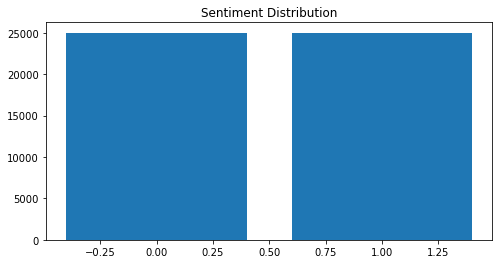

In [6]:
val_count = data_frame.sentiment.value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Sentiment Distribution")

In [7]:
print(val_count)

1    25000
0    25000
Name: sentiment, dtype: int64


### We need to remove hyperlinks from the text - define a regex here to use

In [8]:

"""
preprocess-twitter.py

Script for preprocessing tweets by Romain Paulus

Translation of Ruby script to create features for GloVe vectors for Twitter data.
http://nlp.stanford.edu/projects/glove/preprocess-twitter.rb

this version from gist.github.com/ppope > preprocess_twitter.py

Extended by Manjinder Singh, to enable removal of html entities, and punctuation symbols (except the apostophe)
"""
FLAGS = re.MULTILINE | re.DOTALL

# additional html entities added to remove (Manjinder Singh)
html_entities = [" quot ", " amp ", " lt ", " gt ", " circ ", " tilde ", " ensp ", " emsp ", " thinsp ", " zwnj ", " zwj ", 
                     " lrm ", " rlm ", " ndash ", " mdash ", " lsquo ", " rsquo ", " sbquo ", " ldquo ", " rdquo ", " bdquo ", " permil ", " lsaquo ", " rsaquo "]

def hashtag(text):
    text = text.group()
    hashtag_body = text[1:]
    if hashtag_body.isupper():
        result = "<hashtag> {} <allcaps>".format(hashtag_body.lower())
    else:
        result = " ".join(["<hashtag>"] + re.split(r"(?=[A-Z])", hashtag_body, flags=FLAGS))
    return  result

def allcaps(text):
    text = text.group()
    return text.lower() # removed tag


def tokenize(text):
    
    punctuation = string.punctuation
    punctuation = punctuation.translate({ord(i):None for i in "'"}) # keep the apostrophe
       
    # lower case all text
    text = text.lower()
    # remove extra spaces so we can then remove all amp and quot chars correctly, also removes trailing spaces
    text = ' '.join(text.split()) 
    
    
    # Different regex parts for smiley faces
    eyes = r"[8:=;]"
    nose = r"['`\-]?"

    # function so code less repetitive
    def re_sub(pattern, repl):
        return re.sub(pattern, repl, text, flags=FLAGS)

    text = re_sub(r"https?:\/\/\S+\b|www\.(\w+\.)+\S*", "") # url
    text = re_sub(r"@\w+", "") # twitter username
    text = re_sub(r"&\w+", "") # remove html entities starting with a &
    text = re_sub(r"{}{}[)dD]+|[)dD]+{}{}".format(eyes, nose, nose, eyes), "") # smile
    text = re_sub(r"{}{}p+".format(eyes, nose), "") # lolface
    text = re_sub(r"{}{}\(+|\)+{}{}".format(eyes, nose, nose, eyes), "") # sadface
    text = re_sub(r"{}{}[\/|l*]".format(eyes, nose), "") # neutralface
    text = re_sub(r"/"," / ")
    text = re_sub(r"<3","") # heart
    text = re_sub(r"[-+]?[.\d]*[\d]+[:,.\d]*", "") # remove numbers
    text = re_sub(r"#\w+", "")  # remove hashtag
    text = re_sub(r"([!?.]){2,}", r"\1 ") # remove punctuation repetitions eg. "!!!" 
    text = re_sub(r"\b(\S*?)(.)\2{2,}\b", r"\1\2 ") # remove elongated words and trim eg. shorten 'Awwwwwwwww' to 'Aw'
    

    ## -- I just don't understand why the Ruby script adds <allcaps> to everything so I limited the selection.
    # text = re_sub(r"([^a-z0-9()<>'`\-]){2,}", allcaps)
    #text = re_sub(r"([A-Z]){2,}", allcaps)  # moved below -amackcrane

    # amackcrane additions
    text = re_sub(r"([a-zA-Z<>()])([?!.:;,])", r"\1 \2")
    text = re_sub(r"\(([a-zA-Z<>]+)\)", r"( \1 )")
    text = re_sub(r"  ", r" ")
    #text = re_sub(r" ([A-Z]){2,} ", allcaps) # lowercase all caps
    
    
    # finally remove all punctuation and numbers
    text  = "".join([char for char in text if char not in punctuation])
    text = re.sub('[0-9]+', '', text)
    
    # remove all html entities
    for h in html_entities:
        if h in text:
            text = re_sub(h, "")
    

    return text.lower()

from io import StringIO
from html.parser import HTMLParser

class MLStripper(HTMLParser):
    def __init__(self):
        super().__init__()
        self.reset()
        self.strict = False
        self.convert_charrefs= True
        self.text = StringIO()
        
    def handle_data(self, d):
        self.text.write(d)
        
    def get_data(self):
        return self.text.getvalue()

def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()


### Use the regex to clean all our text entries and write back to the data frame

In [9]:
data_frame.text = data_frame.text.apply(lambda x: strip_tags(x))
data_frame.text = data_frame.text.apply(lambda x: tokenize(x))


# save the cleaned dataset
data_frame.to_csv("dataset/IMDB_clean_data.csv", index = False)

In [10]:
# clean data file
data_frame.head()

,sentiment,text
0,0,i found the documentary entitled fast cheap ...
1,0,this is an embarrassment to everyone and every...
2,0,the cast although nothing special all do an o...
3,0,investigative reporter darren mcgavin as carl ...
4,0,this movie is horrible everything in it has b...


# Wordcloud of ```positive``` sentiments

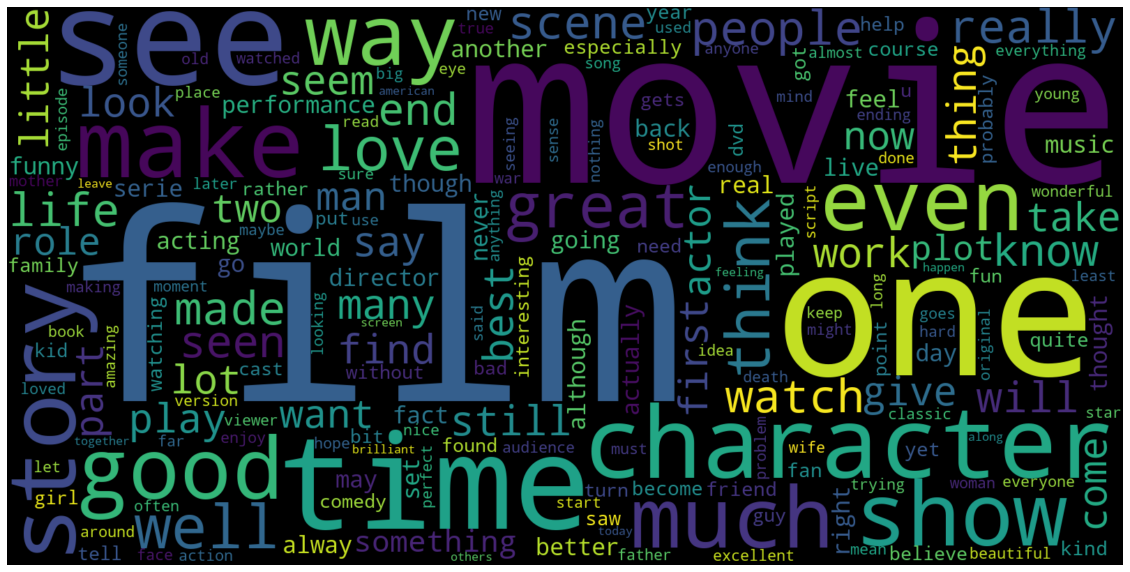

In [11]:


plt.figure(figsize = (20,20)) 
wc = WordCloud(stopwords = STOPWORDS, width = 1600 , height = 800).generate(" ".join(data_frame[data_frame.sentiment == 1].text))
plt.imshow(wc , interpolation = 'bilinear')
plt.axis("off")
plt.show()

# Wordcloud of ```negative``` sentiments

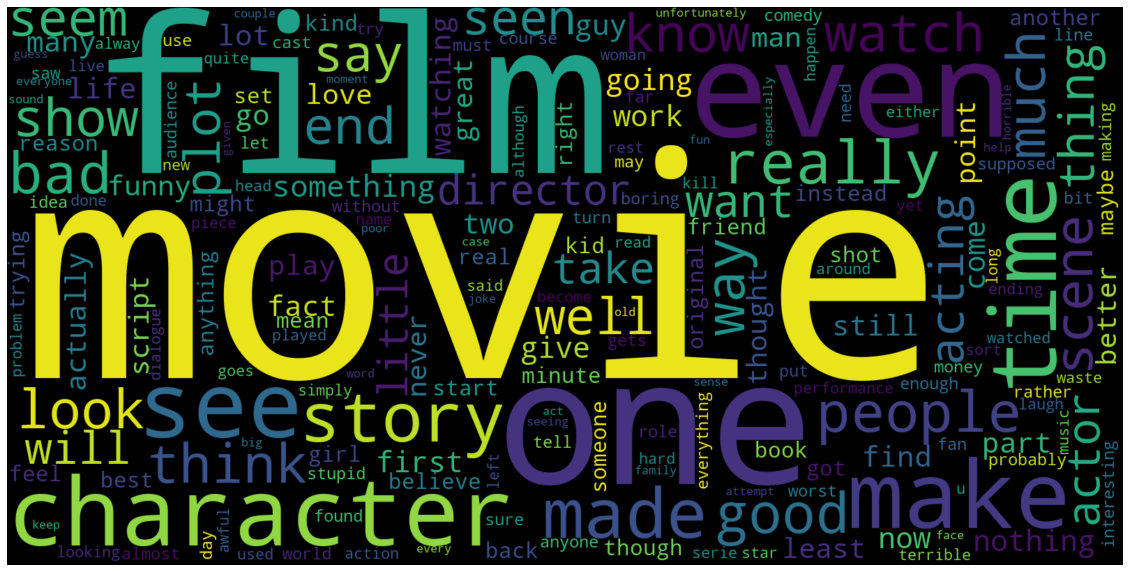

In [12]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(stopwords = STOPWORDS, width = 1600 , height = 800).generate(" ".join(data_frame[data_frame.sentiment == 0].text))
plt.imshow(wc , interpolation = 'bilinear')
plt.axis("off")
plt.show()

### Now we need randomise the dataset

In [13]:
data_frame = data_frame.sample(frac = 1, random_state = 7) # frac = 1 i.e. the entire data frame, random_state = Seed for the random number generator 

In [14]:
data_frame.head()

,sentiment,text
4430,1,this is a delightful movie that is so overthet...
2750,1,after i watched the films i thought why the...
22782,1,this short deals with a severely critical writ...
10498,0,just cause is one of those films that at first...
24747,0,for reasons i cannot begin to fathom dr lore...


### Now we split the data set into 80% for training and 20% for testing
#### This will also shuffle the data set before splitting it

In [15]:
train_size, test_size = train_test_split(data_frame, test_size= (1 - TRAINING_SPLIT), random_state = 7)

In [16]:
print("Training Data:\t",len(train_size), " data points")
print("Test Data:\t",len(test_size), " data points")

Training Data:	 40000  data points
Test Data:	 10000  data points


### Examine the training and test data sets

#### Training dataset

In [17]:
train_size.head()

,sentiment,text
752,1,ingrid bergman is a temporarily impoverished p...
20064,1,meryl streep as kate a woman dying of cancer ...
17924,1,twins effect starring some of hk's most popul...
10658,0,no matter how well meaning his message is thi...
7321,1,my wife and i have watched this movie twice b...


#### Testing dataset

In [18]:
test_size.head()

,sentiment,text
11359,1,at first i hadn't read the novel so far and i...
9729,0,the fact that this movie has been entitled to ...
15270,0,this movie would receive a much higher vote fr...
15015,1,i had no expectations never saw previews for m...
16391,1,this is an excellent movie that tackles the is...




# Tokenization of training data
- We will use the TensorFlow (Keras) Tokenizer class to tokenize our training data (see imports above)
- We define some hyperparameters we will use when performing tokenization
- First we create the Tokenizer object as well as an out of vocabulary token (oov_token) to use for encoding test data words we have not come across in our training, if we don't do this then previously-unseen words would never be unaccounted for. 
- After the Tokenizer has been created, we then fit it on the training data (we do the same for our test dataset).

<center>
<img src="images/tokenization-manning.png">
</center>



    
<center><strong>Francois Chollet. 2017. Deep Learning with Python (1st. ed.). Manning Publications Co., USA.</strong></center>
    


In [19]:
# hyper parameters provided to tokenizer

"""
the UNK token which will be used for out of vocabulary tokens encountered during the 
tokenizing and encoding of the test data sequences created using the word index built during 
tokenization of our training data.
"""
oov_token = '<UNK>'


"""
When we are encoding our numeric sequence representations of the text data, our tweet
string lengths will be of different lengths and so we will need to select a maximum length 
for tweets and pad shorter tweets with a padding character.

We will first calculate the size of the largest tweet string, and then use '0' as a padding character, to pad out shorter
tweets. This ensures all our sequenes of text are of the same length.

Here are specifying that we want the padding at the end of the sequence of tokens
"""
pad_type = 'post'



In [20]:
# Tokenize training data 
tokenizer = Tokenizer(oov_token=oov_token)

# fit to our training dataset
tokenizer.fit_on_texts(train_size.text)


# store the training datas word_index
"""
The okenization process also creates a word index. This  maps words in our 
vocabulary to their numeric representation.

This mapping is then used to encoding our sequences. 
"""
word_index = tokenizer.word_index



# Encode the training tweet sentence into sequences
"""
After tokenizing our training data we have a word-to-numeric 
mapping of our vocabulary, this is used to encode our sequences. 

Here, we are converting our text sentences from something  like 
"the cat sat on the mat" to something like "3 6 7 2 1 4" where each of 
these numbers matches to the index of the corresponding words. 

Since Neural Networks work erforming computation on numbers, 
passing in set of strings will not work. Which is why we need these sequences.

So far, this is only the training dataset, the test dataset has to be
tokenized and encoded after we have competed the training dataset.
"""
train_sequences = tokenizer.texts_to_sequences(train_size.text)

# Get max training sequence length and double it (in case our training
# dataset has a longer sequence - we don't want it truncated)
"""
To ensure that all our sequences are of the same length, we need to set the 
maxlen hyperparameter. Here we set it to twice the maximum length found in
our training dataset sequences.
"""
maxlen = max([len(x) for x in train_sequences]) * 2

# Pad the training sequences
"""
The encoded sequences need to be the same length. 

We use the maxlen found above to set this length. This will 
pad all other sequences with extra '0's at the end ('post').
"""
train_x = pad_sequences(train_sequences, padding=pad_type, maxlen=maxlen)


# Check results of tokenization and creation of training sequences

In [21]:

print("Padded Training Shape:", train_x.shape,"\n")
print("maxlen (maximum length of sequences):", maxlen,"\n")


print("\nExample Training Sequences:\n",train_sequences[1])
print("\nExample Padded Training Sequences:\n",train_x[0])


Padded Training Shape: (40000, 4884) 

maxlen (maximum length of sequences): 4884 


Example Training Sequences:
 [4533, 3998, 14, 2453, 4, 254, 1653, 5, 4651, 4785, 40, 211, 7919, 55, 575, 57, 13, 56, 16, 32, 888, 8, 2, 171, 57, 1623, 12, 2865, 3, 22533, 12137, 23, 39, 14, 638, 14, 63, 2082, 44, 8, 2, 948, 184, 3, 2, 2013, 57, 4503, 41, 6733, 1368, 3, 63, 563, 5, 11719, 14, 2, 612, 3112, 12, 7, 2, 87, 638, 145, 57, 4503, 40, 558, 73, 67, 506, 97, 72, 5, 252, 5793, 937, 12, 46, 23, 105, 8378, 3, 7325, 38, 1719, 23, 2, 276, 4336, 5, 4, 690, 120, 11, 7, 4, 14420, 17, 3, 2, 269, 152, 614, 270, 11510, 198, 2, 358, 3, 558, 10, 194, 11, 28, 4, 707]

Example Padded Training Sequences:
 [6201 3709    7 ...    0    0    0]


# Tokenization of testing data
- We use the same tokenizer to tokenize the test dataset (similar to above)
- We use the same tokenizer to ensure we are using the same vocabulary. 
- We also pad to the same length (maxlen) as the training dataset

In [22]:
test_sequences = tokenizer.texts_to_sequences(test_size.text)
test_x = pad_sequences(test_sequences, padding=pad_type, maxlen=maxlen)

In [23]:
print("Padded Testing Shape:", test_x.shape,"\n")
print("maxlen (maximum length of sequences):", maxlen,"\n")

print("\nExample Testing sequences:\n",test_sequences[5])
print("\nExample Padded Testing Sequences:\n",test_x[9])

# print the first entry only, to show the actual text as a padded sequqnce
for x, y in zip(test_size.text, test_x):
    print("\n\n",'{} \n-> {}'.format(x, y))
    break

Padded Testing Shape: (10000, 4884) 

maxlen (maximum length of sequences): 4884 


Example Testing sequences:
 [7960, 4, 19, 12, 29184, 2, 551, 16882, 8, 691, 1065, 204, 43, 344, 20, 36, 105, 12418, 12, 43, 1342, 2747, 905, 2, 109499, 2, 17, 122, 1426, 4, 584, 31, 2, 6019, 2024, 532, 107, 31, 2, 1495, 3, 28, 8829, 20, 434, 19, 5, 2, 6425, 398, 63, 434, 313, 5, 1038, 3, 8464, 30, 18, 30, 8, 30, 32, 2001, 2320, 5, 691, 204, 7638, 436, 3, 41584, 109497]

Example Padded Testing Sequences:
 [   2 3564    5 ...    0    0    0]


 at first  i hadn't read the novel so far and i hadn't hear anything about the author yet  but as i casually saw this movie  i was totally captive by the story  already as the jewish watchman primary said  that he knows no one  who have a bad conscience about the war except from howard w  campbell junior  was such amazing objective and dissociates from simply moralizing the war  terrific  and the fictitious story about the most effective spy for the usa in wwii who 

### There are only two labels in our model (0 = negative, 1 = positive)

In [24]:
print(train_size.sentiment.unique().tolist())


[1, 0]


#### Encode training labels using scikit-learn module sklearn.preprocessing.LabelEncoder

In [25]:
encoder = LabelEncoder()
encoder.fit(train_size.sentiment.to_list())

train_y = encoder.transform(train_size.sentiment.to_list())
test_y = encoder.transform(test_size.sentiment.to_list())
# print("Dimensions before reshape: ",train_y.ndim)

# convert the 1 dimensional array into a 2d array as required for training 
train_y = train_y.reshape(-1,1)
test_y = test_y.reshape(-1,1)
# print("Dimensions after reshape: ",train_y.ndim)
print("train_y shape:", train_y.shape)
print("test_y shape:", test_y.shape)


train_y shape: (40000, 1)
test_y shape: (10000, 1)


# Word-Embeddings
#### Word embeddings is a feature vector for each of the words that enbales us to give words a ```context```.
- Instead of creating this ourselves, we will use a pre-trained embddings vectors (GloVe Embeddings)

# DATA FILE LOCATIONS
- DATA_SET_TWITTER = "dataset/train.csv"
- COUNTER_FITTED_vectors = "counter-fitted/counter-fitted-vectors.txt" 
- GLOVE_EMBEDDINGS = "glove/glove.840B.300d.txt"

In [26]:
DIMENSION = 300
LEARNING_RATE = 1e-3
BATCH_SIZE = 64
EPOCHS = 10
MODEL_SAVE_PATH = "model/model.hdf5"

# Functions to:
- #### Create and return an embeddings model as a dictionary ```def load_embeddings_model(embeddings_file: str) -> dict:```
- #### Create and return an embeddings matrix ```def get_embeddings_matrix(embeddings_file: str, max_vocabulary_size: int, dimension=300) -> np.ndarray:```
- #### Save a numpy array to file ```def save_numpy_array_to_file(full_path_to_file: str, max_vocabulary_size: int, npy_array: np.ndarray):```

In [27]:
MAX_VOCABULARY_SIZE = len(tokenizer.word_index) + 1

# def create_embeddings(e_file: str):
     
#     dictionary = dict()
#     dictionary['UNK'] = MAX_VOCABULARY_SIZE
    
#     inv_dictionary = dict()
#     inv_dictionary [MAX_VOCABULARY_SIZE] = 'UNK'
    
#     full_dictionary = dict()
#     inv_full_dictionary = dict()
    
#     embeddings_index = {}
#     print("Opening and parsing file, please wait while we load embeddings ...")
#     with open(e_file, 'r', encoding="utf8") as f:
#         for line in f:
#             row = line.strip().split(' ')
#             word = row[0]
#             embedding = np.array([float(val) for val in row[1:]])
#             embeddings_index[word] = embedding
#         print("Completed! Loaded ", len(embeddings_index), " words.")
        
#     for word, w_index in tokenizer.word_index.items():
#         if w_index < MAX_VOCABULARY_SIZE:
#             inv_dictionary[w_index] = word
#             dictionary[word] = w_index
#         full_dictionary = w_index
#         inv_full_dictionary[w_index] = word
              
#     return embeddings_index, dictionary, full_dictionary 

# def create_embeddings_matrix(glove_embeddings_index, dictionary,full_dictionary, dimension=300):
    
#     VOCAB_SIZE = len(dictionary)
#     embedding_matrix = np.zeros((VOCAB_SIZE + 1,dimension))
    
#     words_not_found_counter = 0
#     words_not_found = []
#     print("\nCreating embeddings matri, please wait ...")
#     for w, i in dictionary.items():
#         if not w in glove_embeddings_index:
#             words_not_found_counter += 1
#             words_not_found.append(i)
#         else:
#             #print("w: ", w," i: ", i)
#             embedding_matrix[:,i] = glove_embeddings_index[w]
            
#     print("Embeddings matrix built!")
#     print("Total words not found: ", words_not_found_counter)
    
#     return embedding_matrix, words_not_found
                


    
def load_embeddings_model(embeddings_file: str) -> dict:
    embeddings_model= {}
    
    print("Loading embeddings model to dictionary, please wait...")
    with open(embeddings_file, 'r', encoding="utf8") as f:
        for line in f:
            values = line.strip().split(' ')
            word = value = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_model[word] = coefs

    print("Finished!")
    print('Found %s word vectors in model.' %len(embeddings_model))
    return embeddings_model
    
def get_embeddings_matrix(embeddings_file: str, max_vocabulary_size: int, dimension: int) -> np.ndarray:
    
    # load a pre-trained embeddings model into a dictionary
    embeddings_model = load_embeddings_model(embeddings_file)
    
    print("\nCreating embeddings matrix ...")
    embedding_matrix = np.zeros((max_vocabulary_size, dimension))
    
    for word, i in word_index.items():
        embedding_vector = embeddings_model.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    print("Finished!")        
    return embedding_matrix
    
def save_numpy_array_to_file(full_path_to_file: str, max_vocabulary_size: int, npy_array: np.ndarray):
    
    print("Saving file please wait...")
    full_path_to_file = full_path_to_file+"_%d.npy" % max_vocabulary_size
    np.save(full_path_to_file,npy_array) 
    print("Finished!")
    print("Saved file to: ",full_path_to_file)
    
    


# Create embeddings matrix of words found in Twitter dataset

In [28]:

glove_embeddings_matrix  = get_embeddings_matrix(GLOVE_EMBEDDINGS, MAX_VOCABULARY_SIZE, DIMENSION)


Loading embeddings model to dictionary, please wait...
Finished!
Found 2196007 word vectors in model.

Creating embeddings matrix ...
Finished!


### Shape of GloVe embeddings matrix

In [29]:

print(glove_embeddings_matrix.shape)


(139121, 300)


### Save GloVe Embeddings Matrix to file

In [30]:

# save glove embeddings for words found to the embedding directory
full_path_to_file = "embeddings/imdb_glove_embeddings"
save_numpy_array_to_file(full_path_to_file, MAX_VOCABULARY_SIZE, glove_embeddings_matrix)


Saving file please wait...
Finished!
Saved file to:  embeddings/imdb_glove_embeddings_139121.npy


# Create attack embeddings matrix for our vocabulary
#### (This will be used when generating attacks against the model)

In [31]:

counter_embeddings_matrix  = get_embeddings_matrix(COUNTER_FITTED_VECTORS, MAX_VOCABULARY_SIZE, DIMENSION)


Loading embeddings model to dictionary, please wait...
Finished!
Found 65713 word vectors in model.

Creating embeddings matrix ...
Finished!


### Shape of our vocabulary matrix

In [32]:

print(glove_embeddings_matrix.shape)


(139121, 300)


### Save our vocabulary embeddings matrix

In [33]:

# save the counter fitted embeddings for words found
full_path_to_file = "embeddings/imdb_counter_fitted_embeddings"
save_numpy_array_to_file(full_path_to_file, MAX_VOCABULARY_SIZE, counter_embeddings_matrix)


Saving file please wait...
Finished!
Saved file to:  embeddings/imdb_counter_fitted_embeddings_139121.npy


# Check we have a GPU available for traiing the model
#### (If no GPU available then training will be done using the CPU, which is very slow!)

In [34]:


#print("Number of GPUs available: ", len(tf.config.experimental.list_physical_devices('GPU')))



if tf.test.gpu_device_name(): 
    print('GPU Device used for training will be: {}'.format(tf.test.gpu_device_name()))
else:
    print("No GPU, make sure using a GPU enabled machine, or check you have GPU version of Tensorflow")

GPU Device used for training will be: /device:GPU:0


# Train the sentiment analysis model

In [35]:
import numpy as np

# get the saved GloVe embeddings matrix
glove_embeddings_matrix = np.load(("embeddings/imdb_glove_embeddings_%d.npy" % MAX_VOCABULARY_SIZE))


# Generate our embedding layer for model training

In [36]:
max_len = maxlen
DIMENSION = 300
# train_x 
#train_y

#test_x 
#test_y

batch_size = 64
lstm_size = 128
num_epochs = 10
vocabulary_size = glove_embeddings_matrix.shape[0]
print(vocabulary_size)

139121


In [37]:

#def build_sentiment_analysis_model(batch_size, vocabulary_size,maxlen,lstm_size,embeddings_dimension, keep_probabilities):

embedding_layer = tf.keras.layers.Embedding(vocabulary_size,
                                          DIMENSION,
                                          weights=[glove_embeddings_matrix],
                                          input_length=max_len,
                                          trainable=False)
    

In [38]:

from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint


In [39]:
# sequence_input = Input(shape=(max_len,), dtype='int32')
# embedding_sequences = embedding_layer(sequence_input)
# x = SpatialDropout1D(0.2)(embedding_sequences)
# x = Conv1D(64, 5, activation='relu')(x)
# x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
# x = Dense(512, activation='relu')(x)
# x = Dropout(0.5)(x)
# x = Dense(512, activation='relu')(x)
# outputs = Dense(1, activation='sigmoid')(x)
# model = tf.keras.Model(sequence_input, outputs)


sequence_input = Input(shape=(max_len,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(64, 5, activation='tanh')(x)
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0))(x)
x = Dense(512, activation='tanh')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='tanh')(x)
outputs = Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(sequence_input, outputs)


# Triain the model

In [40]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy',
              metrics=['accuracy'])
ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1,
                                     min_lr = 0.01,
                                     monitor = 'val_loss',
                                     verbose = 1)

In [41]:
print("Training on GPU...") if tf.config.list_physical_devices('GPU') else print("Training on CPU...")


Training on GPU...


In [42]:
history = model.fit(train_x, train_y, batch_size=BATCH_SIZE, epochs=10,
                    validation_data=(test_x, test_y), callbacks=[ReduceLROnPlateau])

Epoch 1/10
625/625 [==============================] - 361s 578ms/step - loss: 0.5222 - accuracy: 0.7358 - val_loss: 0.3094 - val_accuracy: 0.8756 - lr: 0.0010
Epoch 2/10
625/625 [==============================] - 361s 578ms/step - loss: 0.3316 - accuracy: 0.8622 - val_loss: 0.2756 - val_accuracy: 0.8906 - lr: 0.0010
Epoch 3/10
625/625 [==============================] - 359s 574ms/step - loss: 0.3008 - accuracy: 0.8779 - val_loss: 0.2645 - val_accuracy: 0.8950 - lr: 0.0010
Epoch 4/10
625/625 [==============================] - 360s 576ms/step - loss: 0.2798 - accuracy: 0.8835 - val_loss: 0.2758 - val_accuracy: 0.8870 - lr: 0.0010
Epoch 5/10
625/625 [==============================] - 360s 576ms/step - loss: 0.2670 - accuracy: 0.8905 - val_loss: 0.2553 - val_accuracy: 0.8993 - lr: 0.0010
Epoch 6/10
625/625 [==============================] - 362s 580ms/step - loss: 0.2556 - accuracy: 0.8971 - val_loss: 0.2505 - val_accuracy: 0.8998 - lr: 0.0010
Epoch 7/10
625/625 [==========================

# Evaluate the model

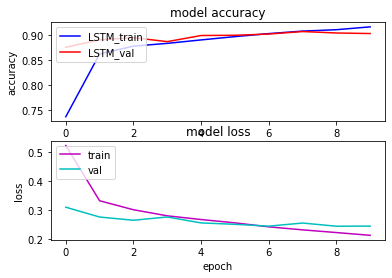

In [43]:
s, (at, al) = plt.subplots(2,1)
at.plot(history.history['accuracy'], c= 'b')
at.plot(history.history['val_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['LSTM_train', 'LSTM_val'], loc='upper left')

al.plot(history.history['loss'], c='m')
al.plot(history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')
s.show()

In [44]:
def decode_sentiment(score):
    return 1 if score>0.5 else 0


scores = model.predict(test_x, verbose=1, batch_size=BATCH_SIZE)
y_predictions = [decode_sentiment(score) for score in scores]


157/157 [==============================] - 45s 284ms/step


In [45]:
import itertools
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
def plot_confusion_matrix(cm, classes, title='Confusion Matrix',cmap=plt.cm.Greys):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=16)
    plt.yticks(tick_marks, classes, fontsize=16)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Actual', fontsize=22)
    plt.xlabel('Predicted', fontsize=17)

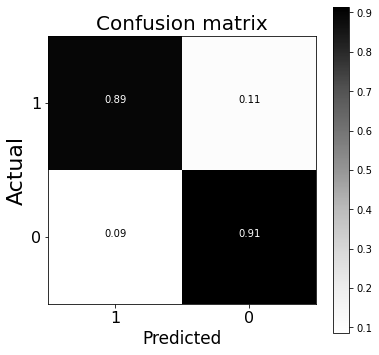

In [46]:
cnf_matrix = confusion_matrix(test_size.sentiment.to_list(), y_predictions)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=test_size.sentiment.unique(), title="Confusion matrix")
plt.show()



In [47]:
print(classification_report(list(test_size.sentiment), y_predictions))

              precision    recall  f1-score   support

           0       0.91      0.89      0.90      4938
           1       0.90      0.91      0.91      5062

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



# Save the model
we can later load it from disk

In [48]:
from keras.models import load_model

model.save('../models/imdb_model.h5')  # creates a HDF5 file 'my_model.h5'
del model  # deletes the existing model

# returns a compiled model
# identical to the previous one
model = load_model('../models/imdb_model.h5')

In [49]:
# model.summary(line_length=None, positions=None, print_fn=None)
# model.get_weights()
# model.get_config()
model.summary()
test_x[0]

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4884)]            0         
_________________________________________________________________
embedding (Embedding)        (None, 4884, 300)         41736300  
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 4884, 300)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 4880, 64)          96064     
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 512)               66048     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0     

array([29, 88, 10, ...,  0,  0,  0], dtype=int32)

In [52]:
import pickle
# save history as a dictionary in case we need to plot again later
with open('../models/trainHistoryDictIMDB.dict', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)
# history = pickle.load(open('/trainHistoryDict'), "rb")